In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from typing import List, Tuple
from sklearn.model_selection import cross_val_score

In [2]:
df_main_train = pd.read_csv(
    "assignment_2_train.csv"
)

df_leader_board = pd.read_csv(
    "assignment_2_test.csv"
)

print("df_main_train.shape = {} rows, {} cols".format(*df_main_train.shape))
#print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_leader_board.shape = {} rows, {} cols".format(*df_leader_board.shape))
df_main_train.head(n=5)

df_main_train.shape = 180000 rows, 394 cols
df_leader_board.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_main_train.loc[:, ['TransactionDT']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   TransactionDT  180000 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [4]:
df_main_train.loc[:, ['TransactionDT']].describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionDT,180000.0,1.909818e+06,1.039029e+06,86400.0,1091680.75,1884075.0,2693195.5,3958317.0


In [71]:
df_leader_board.loc[:, ['TransactionDT']].describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionDT,100001.0,8.696663e+06,760390.854999,7415038.0,8023328.0,8630067.0,9346592.0,10091550.0


In [72]:
pd.to_datetime(df_main_train['TransactionDT'], unit='s').head(n=5)

0   1970-01-02 00:00:00
1   1970-01-02 00:00:01
2   1970-01-02 00:01:09
3   1970-01-02 00:01:39
4   1970-01-02 00:01:46
Name: TransactionDT, dtype: datetime64[ns]

In [5]:
df_main_train.drop(['TransactionDT', 'TransactionID'], axis='columns', inplace=True)
df_leader_board.drop(['TransactionDT', 'TransactionID'], axis='columns', inplace=True)

In [6]:
df_main_train['isFraud'].value_counts()

0    174859
1      5141
Name: isFraud, dtype: int64

Сделаем предобработку, которую сделали на преидущем уроке.

In [8]:
numeric_feature = df_main_train.select_dtypes(include=[np.number]).columns

сategorical_feature = list(set(df_main_train.columns) - set(numeric_feature))

df_main_train_dummy = df_main_train.copy()
#df_valid_dummy = df_valid.copy()
df_leader_board_dummy = df_leader_board.copy()

for i in range(len(сategorical_feature)):
    print(f'feature {сategorical_feature[i]}')
    сategorical_train = df_main_train[сategorical_feature[i]].unique()
    #сategorical_valid = df_valid[сategorical_feature[i]].unique()
    сategorical_test = df_leader_board[сategorical_feature[i]].unique()
    #print(f'сategorical train {сategorical_train}')
    #print(f'сategorical test {сategorical_test}')
    
    #cat_in_feature = list(set(сategorical_train) & set(сategorical_valid) & set(сategorical_test))
    cat_in_feature = list(set(сategorical_train) & set(сategorical_test))
    for cat in cat_in_feature:
        dummie_feature_name = f'{сategorical_feature[i]}_{cat}'
        #print(dummie_feature_name)
        
        if str(cat) != 'nan':
            print(f'    dummie feature name: {dummie_feature_name}')
            df_main_train_dummy[f'{сategorical_feature[i]}_{cat}'] = 0
            df_main_train_dummy.loc[df_main_train_dummy.loc[:,сategorical_feature[i]]==cat, 
                                                          [dummie_feature_name]] = 1      
            
            #df_valid_dummy[f'{сategorical_feature[i]}_{cat}'] = 0
            #df_valid_dummy.loc[df_valid_dummy.loc[:,сategorical_feature[i]]==cat, 
            #                                              [dummie_feature_name]] = 1  
            
            df_leader_board_dummy[f'{сategorical_feature[i]}_{cat}'] = 0
            df_leader_board_dummy.loc[df_leader_board_dummy.loc[:,сategorical_feature[i]]==cat, 
                                                          [dummie_feature_name]] = 1 
            
    df_main_train_dummy.drop([сategorical_feature[i]], axis='columns', inplace=True)
    #df_valid_dummy.drop([сategorical_feature[i]], axis='columns', inplace=True)
    df_leader_board_dummy.drop([сategorical_feature[i]], axis='columns', inplace=True)
    
print(f"count of categorical_df_train {df_main_train_dummy.shape}")
#print(f"count of categorical_df_valid {df_valid_dummy.shape}")
print(f"count of categorical_df_test {df_leader_board_dummy.shape}")

feature M3
    dummie feature name: M3_F
    dummie feature name: M3_T
feature M7
    dummie feature name: M7_F
    dummie feature name: M7_T
feature card6
    dummie feature name: card6_credit
    dummie feature name: card6_charge card
    dummie feature name: card6_debit
    dummie feature name: card6_debit or credit
feature M6
    dummie feature name: M6_F
    dummie feature name: M6_T
feature M5
    dummie feature name: M5_T
    dummie feature name: M5_F
feature M1
    dummie feature name: M1_T
    dummie feature name: M1_F
feature M4
    dummie feature name: M4_M1
    dummie feature name: M4_M0
    dummie feature name: M4_M2
feature ProductCD
    dummie feature name: ProductCD_S
    dummie feature name: ProductCD_W
    dummie feature name: ProductCD_R
    dummie feature name: ProductCD_C
    dummie feature name: ProductCD_H
feature M9
    dummie feature name: M9_T
    dummie feature name: M9_F
feature card4
    dummie feature name: card4_american express
    dummie feature name: c

Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [29]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_main_train_dummy, test_size=0.33,  random_state=42)
#df_valid, df_test = train_test_split(df_test, test_size=0.5,  random_state=42)

y_train = df_train['isFraud']
#y_valid = df_valid['isFraud']
y_test = df_test['isFraud']

df_train.drop(['isFraud'], axis='columns', inplace=True)
#df_valid.drop(['isFraud'], axis='columns', inplace=True)
df_test.drop(['isFraud'], axis='columns', inplace=True)

print("df_train.shape = {} rows, {} cols".format(*df_train.shape))
#print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

df_train.shape = 120600 rows, 524 cols
df_test.shape = 59400 rows, 524 cols


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
dtrain = xgb.DMatrix(data=df_train, label=y_train)
#dvalid = xgb.DMatrix(data=df_valid, label=y_valid)
dtest = xgb.DMatrix(data=df_test)

In [31]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [32]:
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.6537
Will train until train-auc hasn't improved in 10 rounds.
[10]	train-auc:0.762991
[20]	train-auc:0.831376
[30]	train-auc:0.857748
[40]	train-auc:0.874935
[50]	train-auc:0.883843
[60]	train-auc:0.890078
[70]	train-auc:0.894584
[80]	train-auc:0.898248
[90]	train-auc:0.901606
[100]	train-auc:0.904582
[110]	train-auc:0.906295
[120]	train-auc:0.90793
[130]	train-auc:0.909089
Stopping. Best iteration:
[127]	train-auc:0.909089



In [33]:
print(f'train: {round(roc_auc_score(y_train, model_xgb.predict(dtrain)), 4)}')
print(f'test: {round(roc_auc_score(y_test, model_xgb.predict(dtest)), 4)}')

train: 0.9091
test: 0.8968


Нууу.... Если не смотреть забись вебинара, то вполне ебе хорошая модель.

In [21]:
df_lb = df_leader_board_dummy.copy()
y_lb = df_lb['isFraud']
df_lb.drop(['isFraud'], axis='columns', inplace=True)

In [34]:
d_leader_board = xgb.DMatrix(data=df_lb)
predict = model_xgb.predict(d_leader_board)
print(f'leader_board: {round(roc_auc_score(y_lb, predict), 4)}')

leader_board: 0.8663


Модель работает.

Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [37]:
df_train, df_test = train_test_split(df_main_train_dummy, test_size=0.33,  random_state=42)
df_valid, df_test = train_test_split(df_test, test_size=0.5,  random_state=42)

y_train = df_train['isFraud']
y_valid = df_valid['isFraud']
y_test = df_test['isFraud']

df_train.drop(['isFraud'], axis='columns', inplace=True)
df_valid.drop(['isFraud'], axis='columns', inplace=True)
df_test.drop(['isFraud'], axis='columns', inplace=True)

print("df_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_valid.shape = {} rows, {} cols".format(*df_valid.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

df_train.shape = 120600 rows, 526 cols
df_valid.shape = 29700 rows, 526 cols
df_test.shape = 29700 rows, 526 cols


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
dtrain = xgb.DMatrix(data=df_train, label=y_train, silent=True)
dvalid = xgb.DMatrix(data=df_valid, label=y_valid, silent=True)
dtest = xgb.DMatrix(data=df_test, silent=True)

In [39]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [40]:
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.6537	valid-auc:0.639367
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.763017	valid-auc:0.760023
[20]	train-auc:0.831483	valid-auc:0.833147
[30]	train-auc:0.86149	valid-auc:0.861984
[40]	train-auc:0.876341	valid-auc:0.875915
[50]	train-auc:0.887317	valid-auc:0.885726
[60]	train-auc:0.89287	valid-auc:0.889469
[70]	train-auc:0.898636	valid-auc:0.895392
[80]	train-auc:0.902108	valid-auc:0.898889
[90]	train-auc:0.905556	valid-auc:0.901927
[100]	train-auc:0.908816	valid-auc:0.904548
[110]	train-auc:0.910637	valid-auc:0.90614
[120]	train-auc:0.912271	valid-auc:0.907484
[130]	train-auc:0.913878	valid-auc:0.908574
[140]	train-auc:0.915395	valid-auc:0.910088
Stopping. Best iteration:
[139]	train-auc:0.915395	valid-auc:0.910088



In [41]:
print(f'train: {round(roc_auc_score(y_train, model_xgb.predict(dtrain)), 4)}')
print(f'valid: {round(roc_auc_score(y_valid, model_xgb.predict(dvalid)), 4)}')
print(f'test: {round(roc_auc_score(y_test, model_xgb.predict(dtest)), 4)}')

train: 0.9154
valid: 0.9101
test: 0.8987


Аналогично с прошлым выводом.

In [42]:
d_leader_board = xgb.DMatrix(data=df_lb)
predict = model_xgb.predict(d_leader_board)
print(f'leader_board: {round(roc_auc_score(y_lb, predict), 4)}')

leader_board: 0.8637


Такая же точность, но неудивительно мы на тех же данных учились, что и первый вариант.

Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [44]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [45]:
np.random.seed(27)
data = xgb.DMatrix(data=df_test.append(df_valid))
predict = model_xgb.predict(data)
scores = create_bootstrap_metrics(y_test.append(y_valid).values, predict, roc_auc_score)

confidence_interval = calculate_confidence_interval(scores)
confidence_interval

(0.895766417022573, 0.9132492614576624)

Text(0.5, 0, 'sampel number')

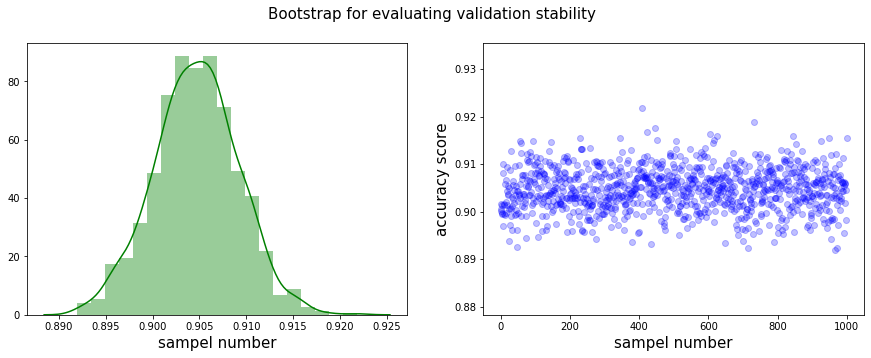

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)

axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("accuracy score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

Точность ЛБ лежит за пределами полученного доверительного интервала, а значит имеются отличия в подопытной и ЛБ выборке.

Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [9]:
df_train = df_main_train_dummy.copy()
df_test = df_leader_board_dummy.copy()

y_train = df_train['isFraud']
y_test = df_test['isFraud']

df_train.drop(['isFraud'], axis='columns', inplace=True)
df_test.drop(['isFraud'], axis='columns', inplace=True)

In [10]:
x_adv = pd.concat([
    df_train, df_test], axis=0
)
y_adv = np.hstack((np.zeros(df_train.shape[0]), np.ones(df_test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [11]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(x_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=25, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
y_pred_adv = model.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.849


In [13]:
y_pred = model.predict_proba(df_train)
y_pred

array([[0.73919415, 0.26080585],
       [0.7452433 , 0.25475672],
       [0.62347555, 0.37652445],
       ...,
       [0.616812  , 0.383188  ],
       [0.78594035, 0.21405967],
       [0.7955502 , 0.2044498 ]], dtype=float32)

In [14]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]        0
(0.1, 0.2]    52018
(0.2, 0.3]    87081
(0.3, 0.4]    24420
(0.4, 0.5]     6228
(0.5, 0.6]    10068
(0.6, 0.7]       47
(0.7, 0.8]       38
(0.8, 0.9]       65
(0.9, 1.0]       35
dtype: int64

In [15]:
df_train = 0
df_test = 0

In [16]:
y_pred = y_pred[:, 1]

In [17]:
valid_lvl_take = 0.4

df_train_best_valid = df_main_train_dummy.copy()

df_train_best_valid['valid_lvl'] = 0
df_train_best_valid['valid_lvl'] = y_pred

df_valid_best_valid = df_train_best_valid.loc[df_train_best_valid.loc[:, 'valid_lvl'] >  valid_lvl_take, :]
df_train_best_valid = df_train_best_valid.loc[df_train_best_valid.loc[:, 'valid_lvl'] <= valid_lvl_take, :]

print("df_train_best_valid.shape = {} rows, {} cols".format(*df_train_best_valid.shape))
print("df_valid_best_valid.shape = {} rows, {} cols".format(*df_valid_best_valid.shape))

y_train_best_valid = df_train_best_valid['isFraud']
y_valid_best_valid = df_valid_best_valid['isFraud']

df_train_best_valid.drop(['isFraud', 'valid_lvl'], axis='columns', inplace=True)
df_valid_best_valid.drop(['isFraud', 'valid_lvl'], axis='columns', inplace=True)

print("df_train_best_valid.shape = {} rows, {} cols".format(*df_train_best_valid.shape))
print("df_valid_best_valid.shape = {} rows, {} cols".format(*df_valid_best_valid.shape))

df_train_best_valid.shape = 163519 rows, 526 cols
df_valid_best_valid.shape = 16481 rows, 526 cols
df_train_best_valid.shape = 163519 rows, 524 cols
df_valid_best_valid.shape = 16481 rows, 524 cols


In [18]:
dtrain = xgb.DMatrix(data=df_train_best_valid, label=y_train_best_valid, silent=True)
dvalid = xgb.DMatrix(data=df_valid_best_valid, label=y_valid_best_valid, silent=True)
#dtest = xgb.DMatrix(data=df_test, silent=True)

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True
)

[0]	train-auc:0.65518	valid-auc:0.516695
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.800807	valid-auc:0.660275
[20]	train-auc:0.832708	valid-auc:0.696955
[30]	train-auc:0.866651	valid-auc:0.785094
[40]	train-auc:0.876027	valid-auc:0.787934
[50]	train-auc:0.887312	valid-auc:0.798821
[60]	train-auc:0.892819	valid-auc:0.799784
[70]	train-auc:0.897593	valid-auc:0.802687
[80]	train-auc:0.900343	valid-auc:0.803958
[90]	train-auc:0.903085	valid-auc:0.805569
[100]	train-auc:0.90551	valid-auc:0.810173
[110]	train-auc:0.907057	valid-auc:0.811304
[120]	train-auc:0.908791	valid-auc:0.814466
[130]	train-auc:0.910224	valid-auc:0.818133
[140]	train-auc:0.911568	valid-auc:0.820358
[150]	train-auc:0.912698	valid-auc:0.824235
[160]	train-auc:0.913752	valid-auc:0.825797
[170]	train-auc:0.914795	valid-auc:0.827609
[180]	train-auc:0.915501	valid-auc:0.828456
Stopping. Best iteration:
[178]	tr

In [22]:
d_leader_board = xgb.DMatrix(data=df_lb)
predict = model_xgb.predict(d_leader_board)
print(f'leader_board: {round(roc_auc_score(y_lb, predict), 4)}')

leader_board: 0.8702


Можно сказать помогло. Но нужно valid_lvl_take угадывать, а это тяжело, когда у тебя нет известной целевой переменной для данных в ЛБ.

Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [23]:
df_train = df_main_train_dummy.copy()

y_train = df_train['isFraud']

df_train.drop(['isFraud'], axis='columns', inplace=True)

In [24]:
%time

model = xgb.XGBRegressor(n_estimators=25)
cv = cross_val_score(
    estimator=model,
    X=df_train,
    y=y_train,
    scoring="roc_auc",
    cv=10
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

Wall time: 0 ns
[23:38:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:41:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:41:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:57] WARNING: src/objective/regression_obj.cu:152:

In [25]:
cv

array([0.79565114, 0.81904561, 0.82269956, 0.85805723, 0.87849707,
       0.81503766, 0.79395842, 0.8441272 , 0.84787698, 0.82018732])

In [26]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        
        estimator.fit(x_train, 
                      y_train)
        
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [27]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model = xgb.XGBRegressor(params=params)

cv_strategy = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    df_train, y_train, model, metric=roc_auc_score, cv_strategy=cv_strategy
)

[23:45:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.8846, valid-score = 0.874
[23:47:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.8848, valid-score = 0.8852
[23:49:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.8858, valid-score = 0.8782
[23:51:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.8822, valid-score = 0.8819
[23:52:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squ

In [28]:
for i, estimator in enumerate(estimators):    
    predict_train = estimator.predict(df_train)  
    predict_lb =    estimator.predict(df_lb) 
    print(f'{i} model df_train: {round(roc_auc_score(y_train, predict_train), 10)} df_leader_board: {round(roc_auc_score(y_lb, predict_lb), 10)}')

0 model df_train: 0.8852608701 df_leader_board: 0.8493360792
1 model df_train: 0.8852608701 df_leader_board: 0.8493360792
2 model df_train: 0.8852608701 df_leader_board: 0.8493360792
3 model df_train: 0.8852608701 df_leader_board: 0.8493360792
4 model df_train: 0.8852608701 df_leader_board: 0.8493360792


Все логично. Мы передали ссылку на модель, а потом обучали не 5 разных моделей, а до обучали одну и туже. и ссылку на одну и туже модель положили в estimators 5 раз.

Как копировать модель непонял потому просто список сделаю.

In [17]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimators_in: list,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        estimator = estimators_in[fold_number]
        
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        
        estimator.fit(x_train, 
                      y_train)
        
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [18]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

models = list()
for i in range(5):
    model = xgb.XGBRegressor(params=params)
    models.append(model)

cv_strategy = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    df_train, y_train, models, metric=roc_auc_score, cv_strategy=cv_strategy
)

[22:56:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.8915, valid-score = 0.8808
[22:58:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.8903, valid-score = 0.8898
[23:00:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.8908, valid-score = 0.8812
[23:02:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.8886, valid-score = 0.8886
[23:04:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:sq

Не хватает ресурсов. вот результат работы ячейки (запускал без целого ноутбука):

In [ ]:
# [22:56:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Fold: 1, train-observations = 144000, valid-observations = 36000
# train-score = 0.8915, valid-score = 0.8808
# =====================================================================
# [22:58:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Fold: 2, train-observations = 144000, valid-observations = 36000
# train-score = 0.8903, valid-score = 0.8898
# =====================================================================
# [23:00:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Fold: 3, train-observations = 144000, valid-observations = 36000
# train-score = 0.8908, valid-score = 0.8812
# =====================================================================
# [23:02:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Fold: 4, train-observations = 144000, valid-observations = 36000
# train-score = 0.8886, valid-score = 0.8886
# =====================================================================
# [23:04:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
# Fold: 5, train-observations = 144000, valid-observations = 36000
# train-score = 0.8908, valid-score = 0.8837
# =====================================================================
# CV-results train: 0.8904 +/- 0.001
# CV-results valid: 0.8848 +/- 0.004
# OOF-score = 0.8847


In [19]:
for i, estimator in enumerate(estimators):    
    predict_train = estimator.predict(df_train)  
    predict_lb =    estimator.predict(df_lb) 
    print(f'{i} model df_train: {round(roc_auc_score(y_train, predict_train), 10)} df_leader_board: {round(roc_auc_score(y_lb, predict_lb), 10)}')
    
# 0 model df_train: 0.8893597582 df_leader_board: 0.8478882774
# 1 model df_train: 0.8901987781 df_leader_board: 0.8468752693
# 2 model df_train: 0.8888658682 df_leader_board: 0.8464260482
# 3 model df_train: 0.8886217251 df_leader_board: 0.8506207201
# 4 model df_train: 0.8893883572 df_leader_board: 0.8502839949


0 model df_train: 0.8893597582 df_leader_board: 0.8478882774
1 model df_train: 0.8901987781 df_leader_board: 0.8468752693
2 model df_train: 0.8888658682 df_leader_board: 0.8464260482
3 model df_train: 0.8886217251 df_leader_board: 0.8506207201
4 model df_train: 0.8893883572 df_leader_board: 0.8502839949


In [ ]:
# Получается дисбаланса данных по выборке особого и нету. 
# Есть огромный дисбаланс целевой переменной, что и проявлялось при других методах и как бы намекало на 
# неравномерность выборки.
# Но Stratified KFold, который производит разделение данных на фолды 
# так, чтобы в каждом фолде было одинаковое распределение целевой переменной показал, что особого отличия среди данных
# по выборке не наблюдается.
# Отличия между трайном и ЛБ не особо велики.
# Точность на моделях от CV ниже получилась, но тут я похоже не добил параметры модели.

